In [163]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)




import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_v3 as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import sys
import matplotlib as mpl

# Clear matplotlib from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith("matplotlib"):
        del sys.modules[module]

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
pt = 1./72.27 
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2
%config InlineBackend.figure_format = 'retina'
obj = lib.Fisher(fmin = 20, fmax = 5000, n_freq = 4000.)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [279]:
names = ['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c']
data = [0,  0,  0, 1.85631014e+00, -7.31174691e-02,  1.05346794e+00, 9.79787100e-01,  0.00000000e+00,  0.00000000e+00]
# picked random angles here

idx = '170817'
# idx = '150914'
if idx=='150914':
    data = np.array(data)
    data[0] = 30
    q  = 0.79
    data[1] = q/(1+q)**2
    data[2] = 390
    dat = jnp.array(data)
elif idx=='170817':
    data = np.array(data)
    data[0] = 1.1
    q  = 0.79
    data[1] = q/(1+q)**2
    data[2] = 40
    dat = jnp.array(data)

red_param = dict(zip(names, jnp.array(dat).T))


epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.
x['s1_x'] = 0.

prec_pe = True
if prec_pe:
    i = None
else:
    i = -2
hgr = obj.get_h_gr(x)
dhgr = obj.get_dh_gr(x)
paramgr = obj.paramdiffgr.copy()[:i]
paramgr_latex = obj.paramdiffgr_latex.copy()[:i]
freqs = obj.freqs.copy()
dets = ["H1", "L1", "V1"]

In [280]:
from scipy.sparse.linalg import eigsh
r = np.loadtxt("data/cache_delta_psi_22_v2.txt")
f_n_orig = np.loadtxt("data/cache_freq_22_v2.txt")
fend = f_n_orig[-1]


μ = np.mean(r, axis=0)
σ = np.var(r, axis=0)**(1/2)
R = r - μ
temp = np.einsum('ij,ik->jk', R, R)  # this computes the outer product of ΔΨ(f)*ΔΨ(f') as 2d array and sums it.
cov = temp/len(r[:,0]) # the two point function is the divided by the number of averages.

nλ = 1
λ, v  = eigsh(cov, nλ)
v = np.sign(v[-1,:])* v

v = 1/1e-3 / 56.41895835477563 *  np.sqrt(λ) * v

# plt.plot(f_n_orig, v)

def get_dpsi_nvnl(freqs, p):
    Mc = p["M_c"]
    eta = p["eta"]
    dPsi = np.sqrt(λ) * v[:,0]
    dPsi = dPsi- dPsi[-1]

    M = pycbc.conversions.mtotal_from_mchirp_eta(Mc,eta)*Ms
    
    # intp = interp.interp1d(f_n_orig, dPsi, kind='linear', fill_value = (0, dPsi[-1]), bounds_error=False)
    # dPsi = intp(freqs*M)
    dPsi = np.interp(freqs*M, f_n_orig, dPsi, left = dPsi[0], right = dPsi[-1])
    return dPsi



In [281]:
def get_stuff(kinj = "nvnl"):
    if kinj=="nvnl":
        
        norm = get_dpsi_nvnl(np.array([20]), x) - get_dpsi_nvnl(np.array([6000]), x)
        dphiA = 1/norm
        dpsi_inj = dphiA*get_dpsi_nvnl(obj.freqs, x)
    else:
        norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
        dphik = 1/norm
        dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    
    Dh = {}
    
    for d in ["H1", "L1", "V1"]:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]]
    norm = np.sum(normarr)**(1/2) / 5
    dpsi_inj = dpsi_inj/norm
    for d in ["H1", "L1", "V1"]:
        Dh[d] = Dh[d]/norm

    # normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]]
    # print(norm)


    fi = obj.compute_joint_fish(x, paramgr, k = None)
    bias_ip = obj.compute_biasip(x, Dh, paramgr, k = None)
    
    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()
    
    cov = jnp.linalg.inv(fi)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)
    xvals = np.array([x[k] for k in paramgr])

    for p in paramgr:
        if log_flag[p]:
            i = idx_par[p]
            dx_bias[i] = dx_bias[i]*x[p]
            dx_stat[i] = dx_stat[i]*x[p]
    # dhpara = np.zeros_like(freqs)
    dhpara = {}
    dhperp = {}
    for d in ["H1", "L1", "V1"]:
        dhpara[d] = jnp.zeros_like(freqs)
        for p in paramgr:
            dhpara[d] = dhpara[d] +  dx_bias[idx_par[p]]*dhgr[d][p]
            # print(lib.innprod( dx_bias[i]*dhgr[d][p], dhpara[d], obj.psdO3, obj.freqs)**(1/2))
        dhperp[d] = Dh[d] - dhpara[d]
    
    dpsi_perp = np.array((dhperp["H1"])/1j/hgr["H1"])

    snr = np.real(np.sum([lib.innprod(hgr[d], hgr[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    snr_dh = np.real(np.sum([lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    snr_dhperp = np.real(np.sum([lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    snr_dhpara = np.real(np.sum([lib.innprod(dhpara[d], dhpara[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    res = {'freqs' : freqs, 'dpsi_inj' : dpsi_inj, 'dpsi_perp' : dpsi_perp, 'dh' : Dh["H1"], 'h' : hgr["H1"], 'dh_perp' : dhperp, 'dx_bias' : dx_bias, 'dx_stat' : dx_stat, 'snr':snr, 'snr_dh':snr_dh, 'snr_dhperp':snr_dhperp, 'snr_dhpara':snr_dhpara}



    return res

/opt/anaconda3/envs/waveform-geometry-tgr/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/waveform-geometry-tgr/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


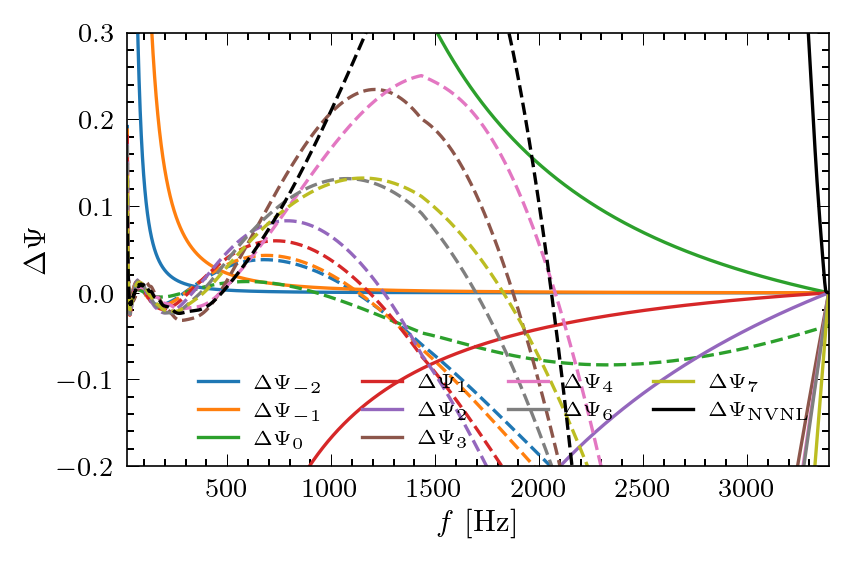

In [282]:
res_nvnl = get_stuff("nvnl")
norm_nvnl = res_nvnl['snr_dhperp']

# sorry about all the norm conventions. I originally had a bunch of guesses but basically I normalize every delta h to be one by doing dh_nvnl / 
for kinj in [-2, -1, 0, 1, 2, 3, 4, 6, 7]:
    res_ppe_k = get_stuff(kinj)

    norm_ppe_k = res_ppe_k['snr_dhperp']
    # print(norm_ppe_k)
    ip_ppe_nvnl = np.sum([lib.innprod(res_nvnl["dh_perp"][d]/norm_nvnl, res_ppe_k["dh_perp"][d]/norm_ppe_k, obj.psdO3, obj.freqs) for d in dets]).real
    ip_ppe_ppe = np.sum([lib.innprod(res_ppe_k["dh_perp"][d]/norm_ppe_k, res_ppe_k["dh_perp"][d]/norm_ppe_k, obj.psdO3, obj.freqs) for d in dets]).real
    dphi_bf = ip_ppe_nvnl / ip_ppe_ppe 

    line, = plt.plot(obj.freqs,dphi_bf*res_ppe_k["dpsi_inj"]/norm_ppe_k, label=rf"$\Delta\Psi_{{ {kinj} }}$")
    line, = plt.plot(obj.freqs,dphi_bf*res_ppe_k["dpsi_perp"]/norm_ppe_k, ls ="--", c= line.get_color())


line, = plt.plot(obj.freqs, res_nvnl["dpsi_inj"]/norm_nvnl, c= "k", label=r"$\Delta\Psi_\mathrm{ NVNL }$")
plt.plot(obj.freqs, res_nvnl["dpsi_perp"]/norm_nvnl, ls ="--", c= line.get_color())
plt.xlim(obj.fmin/1.1, obj.fend * 1.)
plt.ylim(-0.2, 0.3)

plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$\Delta\Psi$")
plt.legend(loc=4,ncols=4)

# plt.savefig("fig7-nvnl-fitting-illustration-150914.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [283]:
obj.fend

Array(3392.40549493, dtype=float64)

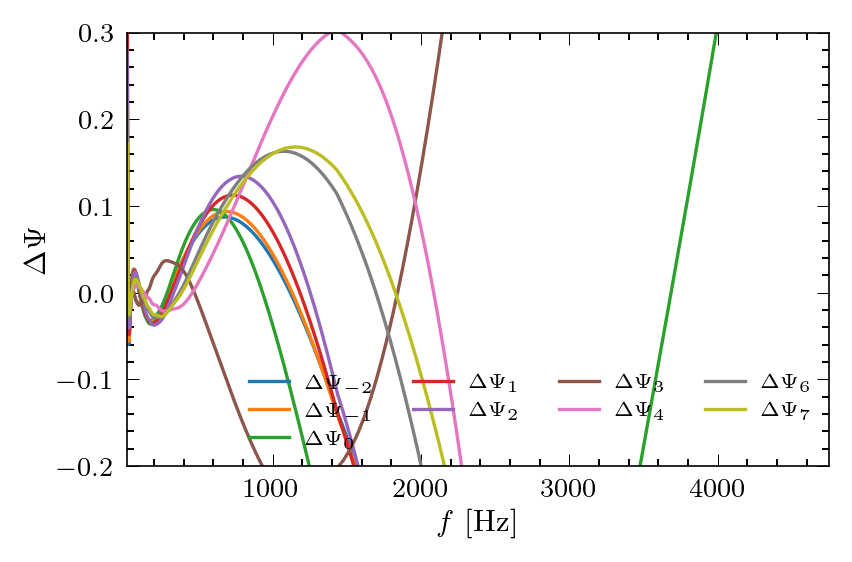

In [284]:
res_nvnl = get_stuff("nvnl")
norm_nvnl = res_nvnl['snr_dhperp']

# sorry about all the norm conventions. I originally had a bunch of guesses but basically I normalize every delta h to be one by doing dh_nvnl / 
for kinj in [-2, -1, 0, 1, 2, 3, 4, 6, 7]:
    res_ppe_k = get_stuff(kinj)

    norm_ppe_k = res_ppe_k['snr_dhperp']
    # print(norm_ppe_k)
    ip_ppe_nvnl = np.sum([lib.innprod(res_nvnl["dh_perp"][d]/norm_nvnl, res_ppe_k["dh_perp"][d]/norm_ppe_k, obj.psdO3, obj.freqs) for d in dets]).real
    ip_ppe_ppe = np.sum([lib.innprod(res_ppe_k["dh_perp"][d]/norm_ppe_k, res_ppe_k["dh_perp"][d]/norm_ppe_k, obj.psdO3, obj.freqs) for d in dets]).real
    dphi_bf = 1 * np.sign((res_ppe_k["dpsi_perp"])[0])

    # line, = plt.plot(obj.freqs,dphi_bf*res_ppe_k["dpsi_inj"]/norm_ppe_k, label=rf"$\Delta\Psi_{{ {kinj} }}$")
    line, = plt.plot(obj.freqs,dphi_bf*res_ppe_k["dpsi_perp"]/norm_ppe_k, label=rf"$\Delta\Psi_{{ {kinj} }}$")


# line, = plt.plot(obj.freqs, res_nvnl["dpsi_inj"]/norm_nvnl, c= "k", label=r"$\Delta\Psi_\mathrm{ NVNL }$")
# plt.plot(obj.freqs, res_nvnl["dpsi_perp"]/norm_nvnl * np.sign((res_nvnl["dpsi_perp"]/norm_nvnl)[0]), c= "k", label=r"$\Delta\Psi_\mathrm{ NVNL }$")
plt.xlim(obj.fmin/1.1, obj.fend * 1.4)
plt.ylim(-0.2, 0.3)

plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$\Delta\Psi$")
plt.legend(loc=4,ncols=4)

# plt.savefig("fig7-nvnl-fitting-illustration-150914.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [285]:
kk = np.array(list(obj.k2str.keys()))
kkvals = kk[kk != 5]

obj.k2str[kkvals[0]]


res_allppe = {}
for i in range(len(kkvals)):
    k_inj = kkvals[i]
    res_allppe[obj.k2str[k_inj]] = get_stuff(k_inj)
    print(kkvals[i], res_allppe[obj.k2str[kkvals[i]]]['snr_dhperp'])

-2 0.09215312180776992
-1 0.03245978563911902
0 0.00020927090757325852
1 0.009372093004118816
2 0.0059051772757385415
3 0.0017864707176017411
4 0.0034578478988822286
6 0.011532749714106364
7 0.009584396562624116


In [286]:
ff = np.zeros((len(kkvals),len(kkvals)),dtype=np.complex128)
for i in range(len(kkvals)):
    for j in range(len(kkvals)):
        norm_1 = res_allppe[obj.k2str[kkvals[i]]]['snr_dhperp'] #* np.sign((res_allppe[obj.k2str[kkvals[i]]]["dpsi_perp"]).real[0])
        norm_2 = res_allppe[obj.k2str[kkvals[j]]]['snr_dhperp'] #* np.sign((res_allppe[obj.k2str[kkvals[j]]]["dpsi_perp"]).real[0])
        dh_1 = res_allppe[obj.k2str[kkvals[i]]]["dh_perp"] 
        dh_2 = res_allppe[obj.k2str[kkvals[j]]]["dh_perp"] 
        s1 = 1 #* np.sign((res_allppe[obj.k2str[kkvals[i]]]["dpsi_perp"]).real[0])
        s2 = 1 #* np.sign((res_allppe[obj.k2str[kkvals[j]]]["dpsi_perp"]).real[0])
        

        ff[i,j] = np.sum([lib.innprod(dh_1[d]*s1, dh_2[d]*s2, obj.psdO3, obj.freqs) for d in dets])/norm_1/norm_2
    print(kkvals[i], norm_1)

-2 0.09215312180776992
-1 0.03245978563911902
0 0.00020927090757325852
1 0.009372093004118816
2 0.0059051772757385415
3 0.0017864707176017411
4 0.0034578478988822286
6 0.011532749714106364
7 0.009584396562624116


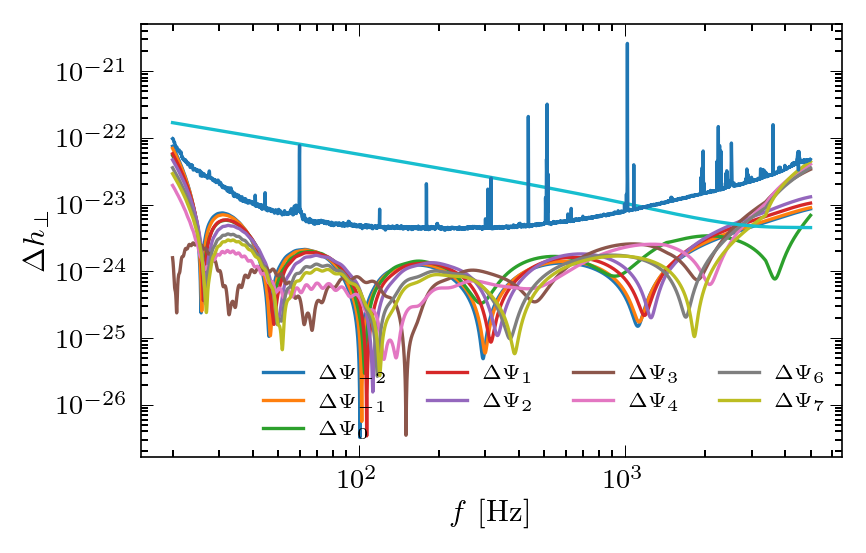

In [287]:
for i in range(len(kkvals)):
    kinj = kkvals[i]
    dh_1 = res_allppe[obj.k2str[kkvals[i]]]["dh_perp"] 
    norm_ppe_k = res_allppe[obj.k2str[kkvals[i]]]['snr_dhperp']
    plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(dh_1["H1"])/norm_ppe_k, label=rf"$\Delta\Psi_{{ {kinj} }}$")

plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(hgr["H1"]))
plt.loglog(freqs, obj.psdO3**(1/2))
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$\Delta h_\perp$")
plt.legend(loc=4,ncols=4)

/var/folders/8k/w_2008p52f36b9xbnhpbpp700000gn/T/ipykernel_24809/3550167663.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


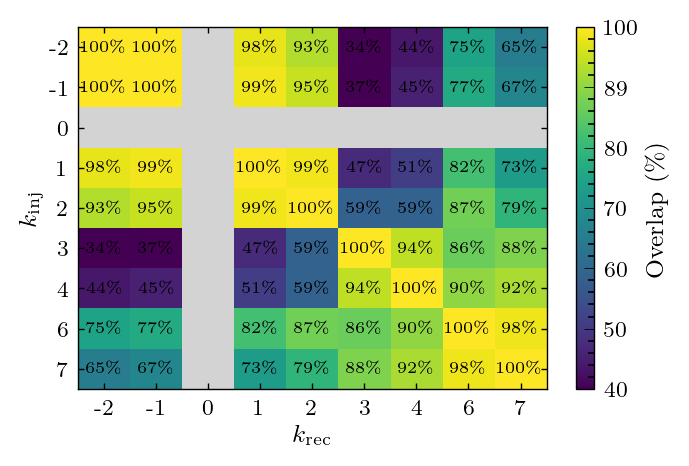

In [293]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter



fig = plt.figure(figsize = (my_width, my_width/golden),dpi=100)
ax = fig.gca()

mmarr = np.abs(ff)

# Ensure values are between 0 and 1 for percentage representation
mmarr_safe = np.clip(mmarr, 0, 1)

# Define levels for percentage scale (0% to 100%)
# levels = np.linspace(0., 1, 11)
# normbar = mcolors.Normalize(vmin=0., vmax=1)
levels = np.linspace(0.4, 1, 7)
normbar = mcolors.Normalize(vmin=0.4, vmax=1)


# build mask: True where we want to grey out (row+col for k==0)
mask = np.zeros_like(mmarr_safe, dtype=bool)
if 0 in kkvals:
    idx0 = np.where(kkvals == 0)[0][0]
    mask[idx0, :] = True
    mask[:, idx0] = True

# masked array so imshow draws masked entries with the "bad" color
mmarr_masked = np.ma.array(mmarr_safe, mask=mask)
cmap = plt.cm.get_cmap("viridis")
cmap.set_bad(color="lightgray")    # masked cells will appear light gray

# Plot using percentage scale
# plt.imshow(mmarr_safe, cmap='viridis', interpolation='nearest', aspect='auto', norm=normbar)
plt.imshow(mmarr_masked, cmap=cmap, interpolation="nearest", aspect="auto", norm=normbar)


# Add discrete color bar
cbar = plt.colorbar(ticks=levels)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x * 100)}"))
cbar.set_label(r'Overlap (\%)')

# Label axes
plt.xlabel(r"$k_{\mathrm{rec}}$")
plt.ylabel(r"$k_{\mathrm{inj}}$")

# Annotate each cell with percentage values
for i in range(len(kkvals)):
    for j in range(len(kkvals)):
        if mask[i, j]:
            continue
        text = fr"{mmarr_safe[i, j] * 100:.0f}\%"  # Convert to percentage
        ax.text(j, i, text, ha="center", va="center", color="k", fontsize=6, weight="bold")

# Set tick labels
labels = kkvals #np.append(kkvals, "NVNL")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

# Adjust tick parameters
ax.tick_params(which='minor', bottom=False, left=False, top=False, right=False)
ax.tick_params(axis='x', length=2, width=0.5)  # Make x-tick marks smaller
ax.tick_params(axis='y', length=2, width=0.5)  # Make y-tick marks smaller

# plt.savefig("ff-pn-tests-spin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-spin-bns.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin-bns.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:

mmarr_masked

masked_array(
  data=[[0.9999999999999993, 0.998245168554123, --,
         0.9769701262241257, 0.9300425145054113,
         0.3391206914216896, 0.4378767359243886,
         0.7475525641627806, 0.654446287388336],
        [0.9982451685541229, 0.9999999999999996, --,
         0.987693684878799, 0.948997403423647,
         0.37138344723073796, 0.4544588418810763,
         0.7673109317467247, 0.6746682341257276],
        [--, --, --, --, --, --, --, --, --],
        [0.9769701262241257, 0.987693684878799, --, 1.0,
         0.9860854896293739, 0.47198144092615896,
         0.5123873082368671, 0.8206278942989678,
         0.7324193086193481],
        [0.9300425145054113, 0.9489974034236471, --,
         0.986085489629374, 1.0, 0.5892975905907752,
         0.5887268147790543, 0.8723080842263705,
         0.793633266700739],
        [0.33912069142168966, 0.371383447230738, --,
         0.471981440926159, 0.5892975905907752, 1.0,
         0.942687210789996, 0.8626672782053031,
         0.884599

In [5]:
kkvals = kk[kk != 5]  # This removes 5 from the array

ff = np.zeros((len(kkvals)+1,len(kkvals)+1),dtype=np.complex128)
for i in range(len(kkvals)):
    for j in range(len(kkvals)):
        dh_1 = res[obj.k2str[kkvals[i]]]
        dh_2 = res[obj.k2str[kkvals[j]]]

        ff[i,j] = np.sum([lib.innprod(dh_1[d], dh_2[d], obj.psdO3, obj.freqs) for d in dets])



for i in range(len(kkvals)):
    dh_1 = res[obj.k2str[kkvals[i]]]
    dh_2 = dhperp_nvnl

    ff[i,len(kkvals)] = np.sum([lib.innprod(dh_1[d], dh_2[d], obj.psdO3, obj.freqs) for d in dets])
    ff[len(kkvals), i] = ff[i,len(kkvals)]

ff[len(kkvals),len(kkvals)] = np.sum([lib.innprod(dhperp_nvnl[d], dhperp_nvnl[d], obj.psdO3, obj.freqs) for d in dets])

ff = np.real(ff)

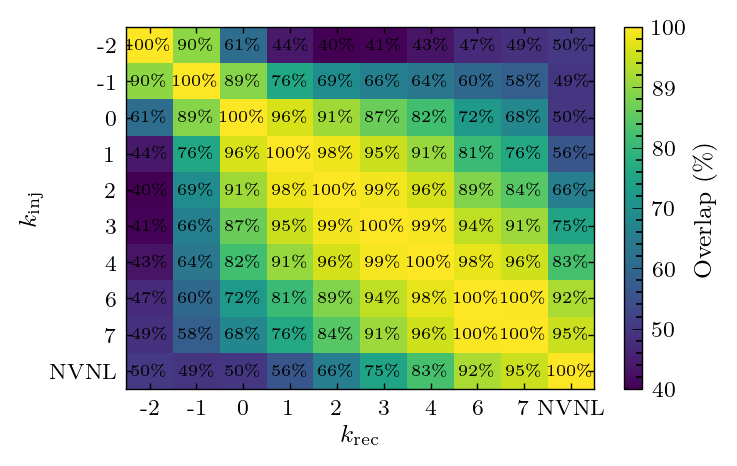

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter



fig = plt.figure(figsize = (my_width, my_width/golden),dpi=100)
ax = fig.gca()

mmarr = np.abs(ff)

# Ensure values are between 0 and 1 for percentage representation
mmarr_safe = np.clip(mmarr, 0, 1)

# Define levels for percentage scale (0% to 100%)
levels = np.linspace(0.4, 1, 7)
normbar = mcolors.Normalize(vmin=0.4, vmax=1)

# Plot using percentage scale
plt.imshow(mmarr_safe, cmap='viridis', interpolation='nearest', aspect='auto', norm=normbar)

# Add discrete color bar
cbar = plt.colorbar(ticks=levels)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x * 100)}"))
cbar.set_label(r'Overlap (\%)')

# Label axes
plt.xlabel(r"$k_{\mathrm{rec}}$")
plt.ylabel(r"$k_{\mathrm{inj}}$")

# Annotate each cell with percentage values
for i in range(len(kkvals)+1):
    for j in range(len(kkvals)+1):
        text = fr"{mmarr_safe[i, j] * 100:.0f}\%"  # Convert to percentage
        ax.text(j, i, text, ha="center", va="center", color="k", fontsize=6, weight="bold")

# Set tick labels
labels = np.append(kkvals, "NVNL")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

# Adjust tick parameters
ax.tick_params(which='minor', bottom=False, left=False, top=False, right=False)
ax.tick_params(axis='x', length=2, width=0.5)  # Make x-tick marks smaller
ax.tick_params(axis='y', length=2, width=0.5)  # Make y-tick marks smaller

# plt.savefig("ff-pn-tests-spin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-spin-bns.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin-bns.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [61]:
x = red_param.copy()
mm = np.linspace(5,80,131)
kk = np.array(list(obj.k2str.keys()))

kkvals = kk[kk != 5]
ol = np.zeros((len(kkvals),len(mm)),dtype=np.complex128)
for m_idx, m in enumerate(mm):
    y = x.copy()
    y["M_c"] = jnp.array(m, dtype=jnp.float64)
    hgr = obj.get_h_gr(y)
    dhgr = obj.get_dh_gr(y)
    fi = obj.compute_fisher_raw(dhgr, y, paramgr)
    # kk = np.array(list(obj.k2str.keys()))
    cov = jnp.linalg.inv(fi)
    res = {}
    resDh = {}
    
    dhperp_nvnl, Dh_nvnl = compute_Dh_nvnl_perp(dhgr, y, paramgr, cov)

    for i in range(len(kkvals)):
        k = kkvals[i]
        dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, y, paramgr, cov)
        ol[i,m_idx]= np.sum([lib.innprod(dhperp_nvnl[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets])



/tmp/ipykernel_2169264/3227889205.py:37: RuntimeWarning: divide by zero encountered in divide
  dphik_guess = 1/norm
/tmp/ipykernel_2169264/3227889205.py:38: RuntimeWarning: invalid value encountered in multiply
  dpsi = dphik_guess* get_dpsi_nvnl(freqs, x)
/tmp/ipykernel_2169264/3227889205.py:42: RuntimeWarning: invalid value encountered in multiply
  Dh[d] = 1j*dpsi*h[d]


/home/darkknight/anaconda3/envs/geotgr/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/darkknight/anaconda3/envs/geotgr/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


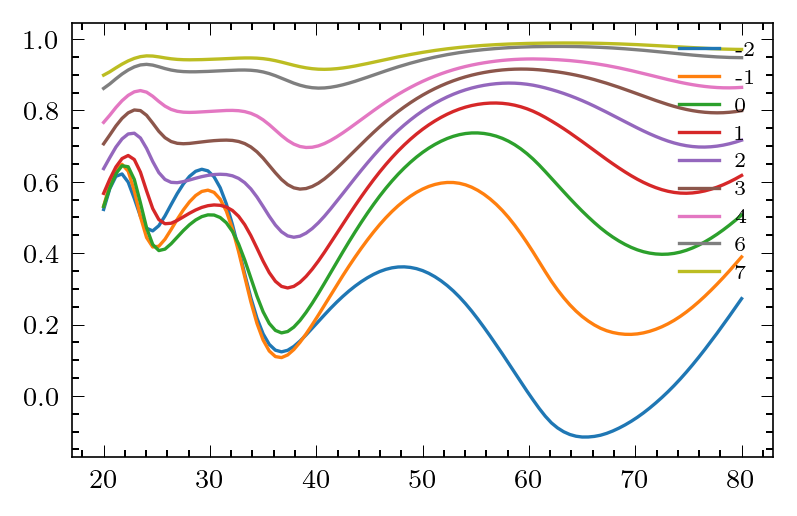

In [62]:
for i in range(len(kkvals)):
    plt.plot(mm,ol[i], label = f"{kkvals[i]}")
plt.legend(loc=1)